This notenook contains feature construction and implementation steps for regression-based recomendations.

In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
def load_pkl(fname):
    with open(fname, 'rb') as infile:
        return pickle.load(infile)
def save_pkl(df, fname):
    with open(fname, 'wb') as outfile:
        pickle.dump(df, outfile)
def na_percent(df):
    return df.isna().sum()/len(df)
def map_customer_id(df):
    df['customer_id'] = df['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
def map_article_id(df):
    df['article_id'] = df['article_id'].astype('int32')
    # when making predictions, should convert to string and add leading 0
    # e.g. train['article_id'] = '0' + train.article_id.astype('str')
path='/content/drive/MyDrive/Colab Notebooks/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

### Process df_transactions_train

Index: (custome_id, article_id) tupes

Features included: 
1. last time the customer have bought the item
2. times the customer have bought the item
3. average price of the item
4. total sale number of the item
5. sale number of the item in the last month 
6. total customer value
7. customer value per purchase
8. last time the customer have made purchase


In [6]:
df_transactions_train = pd.read_csv('../../h-and-m-personalized-fashion-recommendations/transactions_train.csv')
df_customers = pd.read_csv('../../h-and-m-personalized-fashion-recommendations/customers.csv')
df_articles = pd.read_csv('../../h-and-m-personalized-fashion-recommendations/articles.csv')
df_sample_submission = pd.read_csv('../../h-and-m-personalized-fashion-recommendations/sample_submission.csv')

In [7]:
#df_transactions_train = load_pkl(path+'df_transactions_train.pkl')
df_transactions_train["day_num"] = df_transactions_train["year"]*365 + df_transactions_train["month"]*30 + df_transactions_train["day"]

KeyError: 'year'

In [ ]:
last_day = max(df_transactions_train["day_num"])
df_transactions_train1 = df_transactions_train[df_transactions_train["day_num"]<last_day-90]

In [ ]:
df_transactions_train_group = df_transactions_train1[['customer_id', 'article_id', 'day_num']].groupby(['customer_id', 'article_id']).max()
df_transactions_train_group.rename(columns={'day_num':'last_time_the_item'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['customer_id', 'article_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['customer_id', 'article_id', 'day_num']].groupby(['customer_id', 'article_id']).count()
df_transactions_train_group.rename(columns={'day_num':'total_purchase_the_item'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['customer_id', 'article_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['customer_id', 'price']].groupby(['customer_id']).sum()
df_transactions_train_group.rename(columns={'price':'customer_value_total'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['customer_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['customer_id', 'day_num', 'price']].groupby(['customer_id', 'day_num']).sum().groupby(['customer_id']).mean()
df_transactions_train_group.rename(columns={'price':'customer_value_per_purchase'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['customer_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['customer_id', 'day_num']].groupby(['customer_id']).max()
df_transactions_train_group.rename(columns={'day_num':'last_time_ever'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['customer_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['article_id', 'price']].groupby(['article_id']).mean()
df_transactions_train_group.rename(columns={'price':'price_the_item'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['article_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[['article_id', 'day_num']].groupby(['article_id']).count()
df_transactions_train_group.rename(columns={'day_num':'total_sales_the_item'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['article_id'])

In [ ]:
df_transactions_train_group = df_transactions_train1[df_transactions_train1['day_num']>last_day-60][['article_id', 'day_num']].groupby(['article_id']).count()
df_transactions_train_group.rename(columns={'day_num':'last_month_sales_the_item'}, inplace=True)
df_transactions_train = df_transactions_train.join(df_transactions_train_group, on=['article_id'])

In [ ]:
lst = ['total_purchase_the_item', 'total_sales_the_item', 'last_month_sales_the_item']
df_transactions_train[lst] = df_transactions_train[lst].fillna(value=0)

In [ ]:
for col in ['customer_value_total', 'customer_value_per_purchase', 'price_the_item']:
  mean = df_transactions_train[col].mean()
  df_transactions_train[col] = df_transactions_train[col].fillna(value=mean)

In [ ]:
for col in ['last_time_the_item', 'last_time_ever']:
  min = df_transactions_train[col].min()
  df_transactions_train[col] = df_transactions_train[col].fillna(value=min)

In [ ]:
df_transactions_train

In [23]:
save_pkl(df_transactions_train, path + 'regression.pkl')

### Process df_customers

Index: customer_id

Features included:
1. club_member_status with ordianl encoding
2. fashion_news_frequency with ordianl encoding
3. customer's age

In [ ]:
#df_customers = load_pkl(path+'df_customers.pkl')

In [ ]:
df_customers = df_customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age']]

In [ ]:
df_customers = df_customers.fillna('NONE')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


data = np.array([['NONE'], ['LEFT CLUB'], ['PRE-CREATE'], ['ACTIVE']])
cat = list(np.array(['NONE', 'LEFT CLUB', 'PRE-CREATE', 'ACTIVE']).reshape(1,4))
enc = OrdinalEncoder(categories=cat)
enc.fit(data)
encoder = enc.transform(np.expand_dims(list(df_customers['club_member_status']), axis=1))
encoder = encoder.squeeze()
df_customers['club_member_status'] = encoder

In [ ]:
data = np.array([['NONE'], ['Monthly'], ['Regularly']])
cat = list(np.array(['NONE', 'Regularly', 'Monthly']).reshape(1,3))
enc = OrdinalEncoder(categories=cat)
enc.fit(data)
encoder = enc.transform(np.expand_dims(list(df_customers['fashion_news_frequency']), axis=1))
encoder = encoder.squeeze()
df_customers['fashion_news_frequency'] = encoder

In [ ]:
df_customers

,customer_id,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,3.0,0.0,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,3.0,0.0,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,3.0,0.0,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,3.0,0.0,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,3.0,1.0,52.0
...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,3.0,0.0,24.0
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,3.0,0.0,21.0
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,3.0,1.0,21.0
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,3.0,1.0,18.0


In [ ]:
save_pkl(df_customers, path + 'regression_customer.pkl')

### Process df_article

Index: article_id

Features included:
1. product_group_name with onehot encoding
2. perceived_colour with onehot encoding
3. garment_group_name with onehot encoding

In [6]:
#df_articles = pd.read_pickle(path+'df_articles.pkl')

In [7]:
df_articles = df_articles[['article_id','product_group_name','perceived_colour_master_name','garment_group_name']]

In [8]:
df_articles = pd.get_dummies(df_articles, drop_first=True)
df_articles

,article_id,product_group_name_Bags,product_group_name_Cosmetic,product_group_name_Fun,product_group_name_Furniture,product_group_name_Garment Full body,product_group_name_Garment Lower body,product_group_name_Garment Upper body,product_group_name_Garment and Shoe care,product_group_name_Interior textile,...,garment_group_name_Shorts,garment_group_name_Skirts,garment_group_name_Socks and Tights,garment_group_name_Special Offers,garment_group_name_Swimwear,garment_group_name_Trousers,garment_group_name_Trousers Denim,"garment_group_name_Under-, Nightwear",garment_group_name_Unknown,garment_group_name_Woven/Jersey/Knitted mix Baby
0,108775015,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108775044,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,108775051,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,110065001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,110065002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
105538,953763001,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
105539,956217002,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105540,957375001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
save_pkl(df_articles, path + 'regression_article.pkl')

### Regression data

Data: join of df_transactions_train, df_customer and df_article with date < 2020-9-1 (approx.) 

Index: (coustmer_id, article_id) tupes

Features: 14 in total, 9 numerical and 5 categorical ones

Labels: times a customer have bought an item in the last three months, i.e. counts for (customer_id, article_id) in the joint dataset with date >= 2020-9-1 (approx.) 

In [ ]:
df_transactions_train = load_pkl(path + 'regression.pkl')

In [5]:
last_day = max(df_transactions_train["day_num"])
df_transactions_trainy = df_transactions_train[df_transactions_train["day_num"]>=last_day-90]
df_transactions_trainy = df_transactions_trainy[['customer_id', 'article_id', 'day_num']].groupby(['customer_id', 'article_id']).count()
df_transactions_trainy.rename(columns={'day_num':'total_purchase_the_item'}, inplace=True)
save_pkl(df_transactions_trainy, path + 'regression_y.pkl')

In [5]:
first_day = max(-1*df_transactions_train["day_num"])
last_day = max(df_transactions_train["day_num"])

In [6]:
df_transactions_train = df_transactions_train[(df_transactions_train["day_num"]<last_day-90)&(df_transactions_train["day_num"]>first_day+360)]
df_transactions_train.drop(columns=['price', 'sales_channel_id', 'year', 'month', 'day', 'day_num'], inplace=True)
df_transactions_train.drop_duplicates(subset=['customer_id', 'article_id'], inplace=True)

In [7]:
df_customers = load_pkl(path + 'regression_customer.pkl')
df_transactions_trainy = load_pkl(path + 'regression_y.pkl')
df_transactions_train = pd.merge(df_transactions_train, df_customers, on='customer_id', how='left')
df_transactions_train = pd.merge(df_transactions_train, df_transactions_trainy, on=['customer_id', 'article_id'], how='left')
save_pkl(df_transactions_train, path + 'regression_x.pkl')

In [5]:
df_transactions_train = load_pkl(path + 'regression_x.pkl')
df_articles = load_pkl(path + 'regression_article.pkl')
df_transactions_train = pd.merge(df_transactions_train, df_articles, on='article_id', how='left')

In [6]:
save_pkl(df_transactions_train, path + 'regression_x.pkl')

### Regression-based recommendation

Logistic regression predicts the probability of buying (or not buying) a product for each customer. We would recommend to each customer products of >0.5 purchase probability (up to 12 products). Complete with baseline recommendations, if < 12 products.

mAP 0.0066

Rnadom forest regression predict times a customer could buy the product in the future. We would recommend to each customer products of >0 purchase times (up to 12 products). Complete with baseline recommendations, if < 12 products.

mAP 0.0065

In [9]:
X_train = load_pkl(path + 'regression_x.pkl')

In [10]:
y_train = X_train['total_purchase_the_item_y']
y_train = list(y_train.fillna(0))
y_train_0 = [i for i in range(len(y_train)) if y_train[i]==0]
y_train_1 = [i for i in range(len(y_train)) if y_train[i]>0]

In [ ]:
### down sampling
import random
rand = random.sample(range(len(y_train_0)), len(y_train_1))
X_train1 = X_train.iloc[[y_train_0[i] for i in rand] + y_train_1, ]
X_train1['total_purchase_the_item_y'] = X_train1['total_purchase_the_item_y'].fillna(0)
save_pkl(X_train1, path+'X_train1.pkl')

In [10]:
X_train = load_pkl(path+'X_train1.pkl')
X_id = X_train[['customer_id', 'article_id']]
y_train = X_train['total_purchase_the_item_y']
X_train.drop(columns=['customer_id', 'article_id', 'total_purchase_the_item_y'], inplace=True)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

Logistic Regression

In [12]:
X_train['age'] = pd.to_numeric(X_train['age'], errors='coerce')
X_test['age'] = pd.to_numeric(X_test['age'], errors='coerce')
mean = X_train['age'].mean()
X_train['age'] = X_train['age'].fillna(value=mean)

In [13]:
cols = ['last_time_the_item', 'last_time_ever', 'total_sales_the_item', 'age']
scaler = StandardScaler().fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [14]:
X_train['const'] = 1
X_test['const'] = 1

In [18]:
y_train = list(y_train)
y_train_bool = [0 if t==0 else 1 for t in y_train]

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train_bool)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [20]:
mean = X_test['age'].mean()
X_test['age'] = X_test['age'].fillna(value=mean)

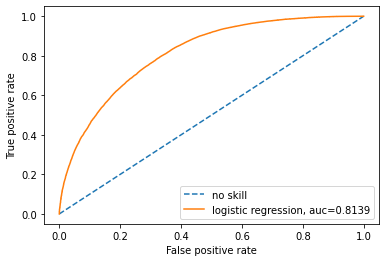

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_test = list(y_test)
y_test_bool = [0 if t==0 else 1 for t in y_test]
fpr, tpr, _ = roc_curve(y_test_bool, [0 for i in y_test_bool])
plt.plot(fpr, tpr, linestyle='--', label='no skill')

pred = clf.predict_proba(X_test)
pred = [p[1] for p in pred]
fpr, tpr, thresh = roc_curve(y_test_bool, pred)
auc = roc_auc_score(y_test_bool, pred)
plt.plot(fpr, tpr, label="logistic regression, auc="+str(round(auc, 4)))
plt.legend(loc=0)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig(path + 'lr.png')

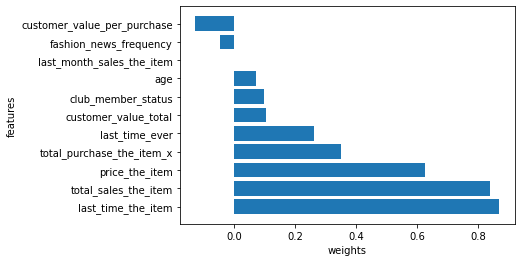

In [29]:
features = list(zip(list(X_train.columns[:11]), [c for c in clf.coef_[0][:11]]))
features.sort(key=lambda x: -1*abs(x[1]))
features = features[:12]
features.sort(key=lambda x: -1*x[1])
plt.barh([f[0] for f in features], [f[1] for f in features])
plt.xlabel('weights')
plt.ylabel('features')
plt.savefig(path + 'lr_numerical.png', bbox_inches = "tight")

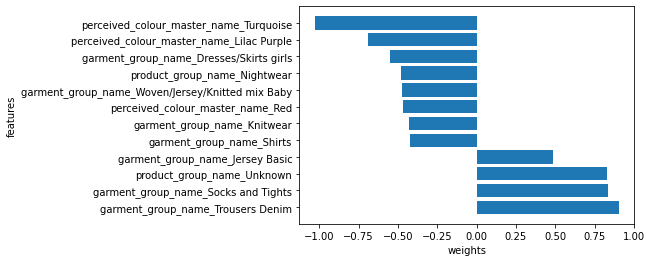

In [30]:
features = list(zip(list(X_train.columns[11:-1]), [c for c in clf.coef_[0][11:-1]]))
features.sort(key=lambda x: -1*abs(x[1]))
features = features[:12]
features.sort(key=lambda x: -1*x[1])
plt.barh([f[0] for f in features], [f[1] for f in features])
plt.xlabel('weights')
plt.ylabel('features')
plt.savefig(path + 'lr_categori.png', bbox_inches = "tight")

In [31]:
X_train = load_pkl(path+'X_train1.pkl')
X_train['age'] = pd.to_numeric(X_train['age'], errors='coerce')
mean = X_train['age'].mean()
X_train['age'] = X_train['age'].fillna(value=mean)

cols = ['last_time_the_item', 'last_time_ever', 'total_sales_the_item', 'age']
scaler = StandardScaler().fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])

X_train['const'] = 1

pred = clf.predict_proba(X_train.drop(columns=['customer_id', 'article_id', 'total_purchase_the_item_y']))
pred = [p[0] for p in pred]
X_train['prob_of_0'] = pred
save_pkl(X_train, path + 'X_train_lr.pkl')

Random Forest Regression

In [6]:
X_train['age'] = pd.to_numeric(X_train['age'], errors='coerce')
X_test['age'] = pd.to_numeric(X_test['age'], errors='coerce')
mean = X_train['age'].mean()
X_train['age'] = X_train['age'].fillna(value=mean)
mean = X_test['age'].mean()
X_test['age'] = X_test['age'].fillna(value=mean)

In [7]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier().fit(X_train.to_numpy(), y_train.to_numpy())

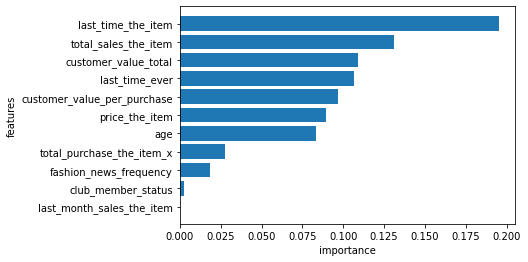

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

features = list(zip(list(X_train.columns[:11]), [c for c in regressor.feature_importances_[:11]]))
features.sort(key=lambda x: -1*abs(x[1]))
features = features[:12]
features.sort(key=lambda x: -1*x[1])
features.reverse()
plt.barh([f[0] for f in features], [f[1] for f in features])
plt.xlabel('importance')
plt.ylabel('features')
plt.savefig(path + 'rf_numerical.png', bbox_inches = "tight")

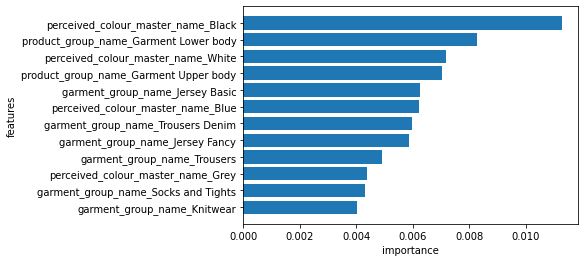

In [9]:
features = list(zip(list(X_train.columns[11:]), [c for c in regressor.feature_importances_[11:]]))
features.sort(key=lambda x: -1*abs(x[1]))
features = features[:12]
features.sort(key=lambda x: -1*x[1])
features.reverse()
plt.barh([f[0] for f in features], [f[1] for f in features])
plt.xlabel('importance')
plt.ylabel('features')
plt.savefig(path + 'rf_categori.png', bbox_inches = "tight")

In [12]:
X_train = load_pkl(path+'X_train1.pk')
X_train['total_purchase_the_item_y'] = X_train['total_purchase_the_item_y'].fillna(0)
y_train = X_train['total_purchase_the_item_y']
X_train.drop(columns=['customer_id', 'article_id', 'total_purchase_the_item_y'], inplace=True)
X_train['age'] = pd.to_numeric(X_train['age'], errors='coerce')
mean = X_train['age'].mean()
X_train['age'] = X_train['age'].fillna(value=mean)

In [ ]:
pred = regressor.predict(X_train)
X_train['pred_of_num'] = pred
save_pkl(X_train, path + 'X_train_rf.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Recommendation submission

In [32]:
#df_sample_submission = pd.read_csv(path+'submission_baseline.csv')

In [33]:
#X_train_rf = load_pkl(path+'X_train_rf.pkl')
#X_train_rf = X_train_rf[X_train_rf['pred_of_num']>0]
X_train_lr = load_pkl(path+'X_train_lr.pkl')
X_train_lr = X_train_lr[X_train_lr['prob_of_0']<0.5]

In [34]:
#X_train_group = X_train_rf[['customer_id', 'article_id', 'pred_of_num']].sort_values(['customer_id','pred_of_num'],ascending=False).groupby('customer_id').head(12)
X_train_group = X_train_lr[['customer_id', 'article_id', 'prob_of_0']].sort_values(['customer_id','prob_of_0'],ascending=True).groupby('customer_id').head(12)
X_train_group = X_train_group.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction2')
X_train_group['prediction2'] = X_train_group['prediction2'].apply(lambda x: '0'+' 0'.join([str(a) for a in x]))

In [35]:
df_sample_submission = pd.merge(df_sample_submission, X_train_group, on='customer_id', how='left')
df_sample_submission['prediction2'] = df_sample_submission['prediction2'].fillna('')

In [36]:
df_sample_submission['prediction'] = df_sample_submission.apply(lambda row: (row['prediction2']+row['prediction'])[:131], axis=1)
df_sample_submission.drop(columns=['prediction2'], inplace=True)

In [37]:
df_sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0841260003 0887593002 0890498002 0795440001 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0351484002 07235290010811835004 0811835004 081...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002 0351484002 0750424014 0750424014 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0730683050 0927530004 0791587015070...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,05575990220826955010 0826955010 0557599022 055...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0699623004 0699623004 0663568009 0663568009 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016002 0689365050 0884081001 0794819001 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0866755002 0866755002 0821395003 0806241002 07...


In [38]:
#df_sample_submission.to_csv(path+'submission_rf.csv', index=False)
df_sample_submission.to_csv(path+'submission_lr.csv', index=False)